# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.
 
__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 5 баллов

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 5 баллов

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

Ваш код обязательно должен проходить все `assert`'ы ниже.

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам.


__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [1]:
# !pip install wandb
!pip3 install pytorch_lightning torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 796 kB 12.8 MB/s 
     |████████████████████████████████| 529 kB 67.3 MB/s 
     |████████████████████████████████| 136 kB 66.7 MB/s 
     |████████████████████████████████| 87 kB 7.1 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=85ea0f113fcef6f9939a7777c0fc4671a4a488b335d5429adccda66a085dad0e
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


In [ ]:
# Возможно ниже будет не очень работать WandbLogger с первого разу, перезапустите kernel тетрадки
# import wandb

# wandb.login()

In [2]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from IPython.display import clear_output

# You may add any imports you need

In [3]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

In [4]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

--2022-11-08 18:58:22--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/33l8lp62rmvtx40/dataset.zip [following]
--2022-11-08 18:58:22--  https://www.dropbox.com/s/dl/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0e6d9b19bf0dbf36c95317637a.dl.dropboxusercontent.com/cd/0/get/Bwbn-zdRr7lF14hHUXRxcn-KFHFTJM6TK5fnG3yDd8bv7J4zWNsEYWUvb2aUja8-CDH2iCMZZZ__dzR4uNW0YUV9I7xHtcXM8FzTlXS7RASI9siAGv0l2HAezDOa42epJRra-cNsTDEGF11-WfqT-7ZEnzZT72beVsLUXoWS55dw9w/file?dl=1# [following]
--2022-11-08 18:58:23--  https://uc0e6d9b19bf0dbf36c95317637a.dl.dropboxusercontent.com/cd/0/get/Bwbn-zdRr7lF14hHUXRxcn-KFHFTJM6TK5fnG3yDd8bv7J4zWNsEYWUvb2aUja8-CDH2iCMZZZ__dz

## Задание 0

### Что поможет сделать на 10 из 10 (одно задание - 5 баллов)

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True) 

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели. 
5. Можно написать модель руками свою в YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать: 

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали. 
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Подготовка данных

In [ ]:
# посчитаем среднее и стандартное отклонение, воспользовавшись функцией с 
# https://towardsdatascience.com/how-to-calculate-the-mean-and-standard-deviation-normalizing-datasets-in-pytorch-704bd7d05f4c

train_dataset = ImageFolder('/content/dataset/dataset/train', transform=transforms.ToTensor())
train_dataloader = DataLoader(dataset=train_dataset, batch_size=32)

def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

get_mean_and_std(train_dataloader)

(tensor([0.4802, 0.4481, 0.3975]), tensor([0.2770, 0.2691, 0.2821]))

In [ ]:
# YOU CAN DEFINE AUGMENTATIONS HERE
seed_everything(123456)
train_transform = transforms.Compose(
    [
        transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2770, 0.2691, 0.2821))
    ]
)
val_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2770, 0.2691, 0.2821))
    ]
)

train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET

train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4
) # YOUR CODE HERE

val_dataloader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4
) # YOUR CODE HERE

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

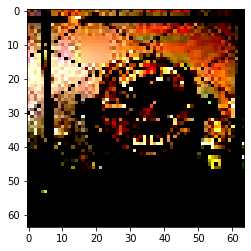

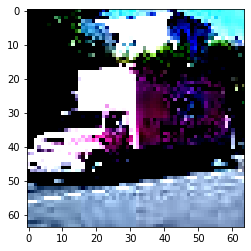

In [ ]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

## Задание 1. 

5 баллов
Добейтесь accuracy на валидации не менее 0.44. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.


Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались)
4. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте не предобученную)

In [ ]:
class YourNet(torch.nn.Module):
    def __init__(self, activation=nn.ReLU):
        super().__init__()
        # YOUR CODE HERE
        self.vgg1 = nn.Sequential(
            # in_channels, out_channels, kernel_size
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            activation(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            activation(),
            # torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
            nn.MaxPool2d(2),
            # nn.Dropout(0.2)
        )

        self.vgg2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            activation(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            activation(),
            nn.MaxPool2d(2),
            # nn.Dropout(0.2)
        )

        self.vgg3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            activation(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            activation(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            activation(),
            nn.MaxPool2d(2),
            # nn.Dropout(0.2)
        )

        self.lin1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 1024),
            nn.BatchNorm1d(1024),
            activation(),
        )

        self.lin2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            activation()
        )

        self.drop = torch.nn.Dropout(0.3)

        self.output = torch.nn.Linear(in_features=512, out_features=200)

        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()


    def forward(self, x):
        # runs the Neural Network
        # YOUR CODE HERE
        
        x = self.vgg1(x)
        x = self.vgg2(x)
        x = self.vgg3(x)
        x = self.lin1(x)
        x = self.drop(x)
        x = self.lin2(x)
        
        return self.output(x)

    # def forward(self, images, target=None):
    #     # YOUR CODE HERE
    #     output = self._forward(images)

    #     # get accuracy score and save it to self.accuracy
    #     if target is not None:
    #         loss = self.loss_func(output, target)

    #         self.targets = torch.cat((self.targets, target.cpu()), 0)
    #         pred = torch.argmax(output, dim=-1)
    #         self.preds = torch.cat((self.preds, pred.cpu()), 0)
    #         self.accuracy = accuracy(self.preds.long(), self.targets.long())

    #     return loss

    # def get_accuracy(self, reset=False):
    #     # YOUR CODE HERE
    #     if reset:
    #         self.targets = torch.Tensor()
    #         self.preds = torch.Tensor()
    #     return self.accuracy

In [5]:
def plot_history(train_history, val_history, title="loss"):
    plt.figure()
    plt.title(title)
    plt.plot(train_history, label="train", zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c="orange", label="val", zorder=2)
    plt.xlabel("train steps")
    
    plt.legend(loc="best")
    plt.grid()

    plt.show()

In [6]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=10):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []
    
    for epoch in range(n_epochs):
        # тренировка
        train_epoch_loss, train_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.train()
        for imgs, labels in tqdm(train_dataloader, desc=f"Training, epoch {epoch}", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            
            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            # log loss for the current epoch and the whole training history
            train_epoch_loss = torch.cat((train_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0)))
            train_loss_log.append(loss.cpu().data / labels.cpu().size(0))

            # log accuracy for the current epoch and the whole training history
            pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
            train_epoch_true_hits = torch.cat((
                train_epoch_true_hits, 
                (pred_classes == labels.cpu()).sum().unsqueeze(0)
            ))
            train_acc_log.append((pred_classes == labels.cpu()).sum() / labels.cpu().shape[0])


        # валидация
        val_epoch_loss, val_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.eval()
        with torch.no_grad():
            for imgs, labels in tqdm(val_dataloader, desc=f"Validating, epoch {epoch}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device)
                
                y_pred = model(imgs)
                loss = criterion(y_pred, labels)
                val_epoch_loss = torch.cat((val_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0)))

                pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
                val_epoch_true_hits = torch.cat((
                    val_epoch_true_hits,
                    (pred_classes == labels.cpu()).sum().unsqueeze(0)
                ))
        
        
        val_loss_log.append(val_epoch_loss.mean())
        val_acc_log.append(val_epoch_true_hits.sum() / val_epoch_true_hits.size(0) / val_dataloader.batch_size)
        clear_output()
        plot_history(train_loss_log, val_loss_log, "loss")
        plot_history(train_acc_log, val_acc_log, "accuracy")

        print("Train loss:", train_epoch_loss.mean().item())
        print(
            "Train acc:", 
            (train_epoch_true_hits.sum() / train_epoch_true_hits.size(0) / train_dataloader.batch_size).item()
        )
        print("Val loss:", val_epoch_loss.mean().item())
        print(
            "Val acc:", 
            (val_epoch_true_hits.sum() / val_epoch_true_hits.size(0) / val_dataloader.batch_size).item()
        )

        if (val_epoch_true_hits.sum() / val_epoch_true_hits.size(0) / val_dataloader.batch_size).item() > 0.8:
          break

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

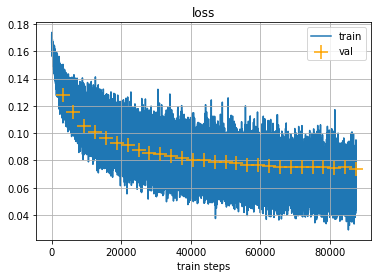

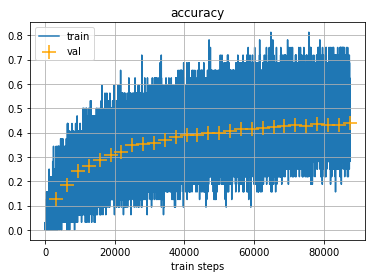

Train loss: 0.06282433867454529
Train acc: 0.4979400038719177
Val loss: 0.07352238148450851
Val acc: 0.4402955174446106


In [ ]:
model_baseline = YourNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_baseline.parameters(), lr=0.001, momentum=0.9)

train(model_baseline, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=30)

### Валидация результатов задания

In [15]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    model.eval()
    accuracy = torch.empty(0)
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            y_pred = model(images)

            pred_classes = torch.argmax(y_pred.cpu(), dim=-1)

            accuracy = torch.cat((
                    accuracy,
                    (pred_classes == labels.cpu()).sum().unsqueeze(0)
                ))

    return (accuracy.sum() / accuracy.size(0) / test_dataloader.batch_size).item()

In [ ]:
model = model_baseline

accuracy = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * accuracy / 0.44, 0, 10):.2f} баллов")

  0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 313/313 [00:05<00:00, 56.26it/s]

Оценка за это задание составит 10.00 баллов


## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте предобученную)

In [9]:
seed_everything(123456)
train_transform2 = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2770, 0.2691, 0.2821))
    ]
)
val_transform2 = torchvision.transforms.Compose(
    [
        transforms.Resize((128, 128)),
        torchvision.transforms.ToTensor(),
        transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2770, 0.2691, 0.2821))
    ]
)

train_dataset2 = ImageFolder('/content/dataset/dataset/train', transform=train_transform2)
val_dataset2 = ImageFolder('/content/dataset/dataset/val', transform=val_transform2)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET

train_dataloader2 = DataLoader(
    train_dataset2,
    batch_size=64,
    shuffle=True,
    num_workers=2
) # YOUR CODE HERE

val_dataloader2 = DataLoader(
    val_dataset2,
    batch_size=64,
    shuffle=True,
    num_workers=2
) # YOUR CODE HERE

In [10]:
model2 = torchvision.models.efficientnet_b1(pretrain=True, weights='DEFAULT')
model2.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(1280, 200),
)
model2.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth


  0%|          | 0.00/30.1M [00:00<?, ?B/s]

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

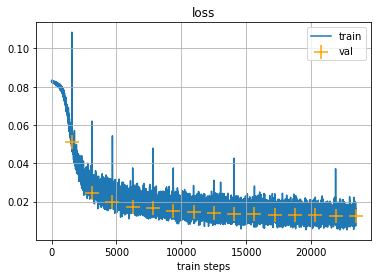

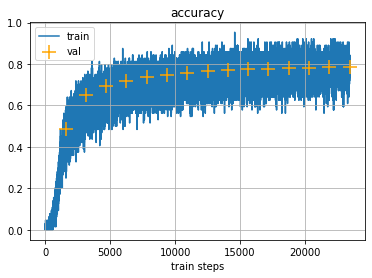

Train loss: 0.01253542024642229
Train acc: 0.7821097373962402
Val loss: 0.01268185954540968
Val acc: 0.7852308750152588


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)

train(model2, criterion, optimizer, train_dataloader2, val_dataloader2, n_epochs=15)

### Валидация результатов задания

In [16]:
model_best = model2

accuracy = evaluate_task(model_best, val_dataloader2)
print(f"Оценка за это задание составит {np.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов")

100%|██████████| 157/157 [00:11<00:00, 13.50it/s]

Оценка за это задание составит 8.39 баллов


# Отчёт об экспериментах 

текст писать тут (или ссылочку на wandb/любой трекер экспреиментов) для каждого задания, то есть не обязательно именно тут рисовать графики, если вы используете готовые трекеры/мониторинги ваших моделей.

Сначала я честно писала все через лайтнинг и трекала обучение в wandb, даже [ссылочку](https://wandb.ai/verabagrova/lightning_logs/runs/n81nmp34?workspace=user-verabagrova) прикреплю. Основной проблемой стало очень долгое обучение, дальше третьей эпохи не доходило и из-за этого было сложно перебирать и подбирать архитектуры. 
В общем, за день до дедлайна стало совсем грустно, поэтому я взяла функции для обучения из семинаров и прогнала на них несколько моделек. За основу взяла vgg16 с меньшим количеством сверток. Пробовала работать на Adam оптимизаторе, но он оказался хуже SGD. Dropout оказался не слишком полезен, с учетом того, что моделька итак не особо хорошее качество показывала...И еще применила нормализацию с точно посчитаным средним и стандартным отклонением, это немного улучшила прогноз. В конце концов получилась относительно стабильная моделька, у которой при увеличении количества эпох росло акураси. Ну и по итогам смены лайтнинга на хардкодинг я не могу не прикрепить это:

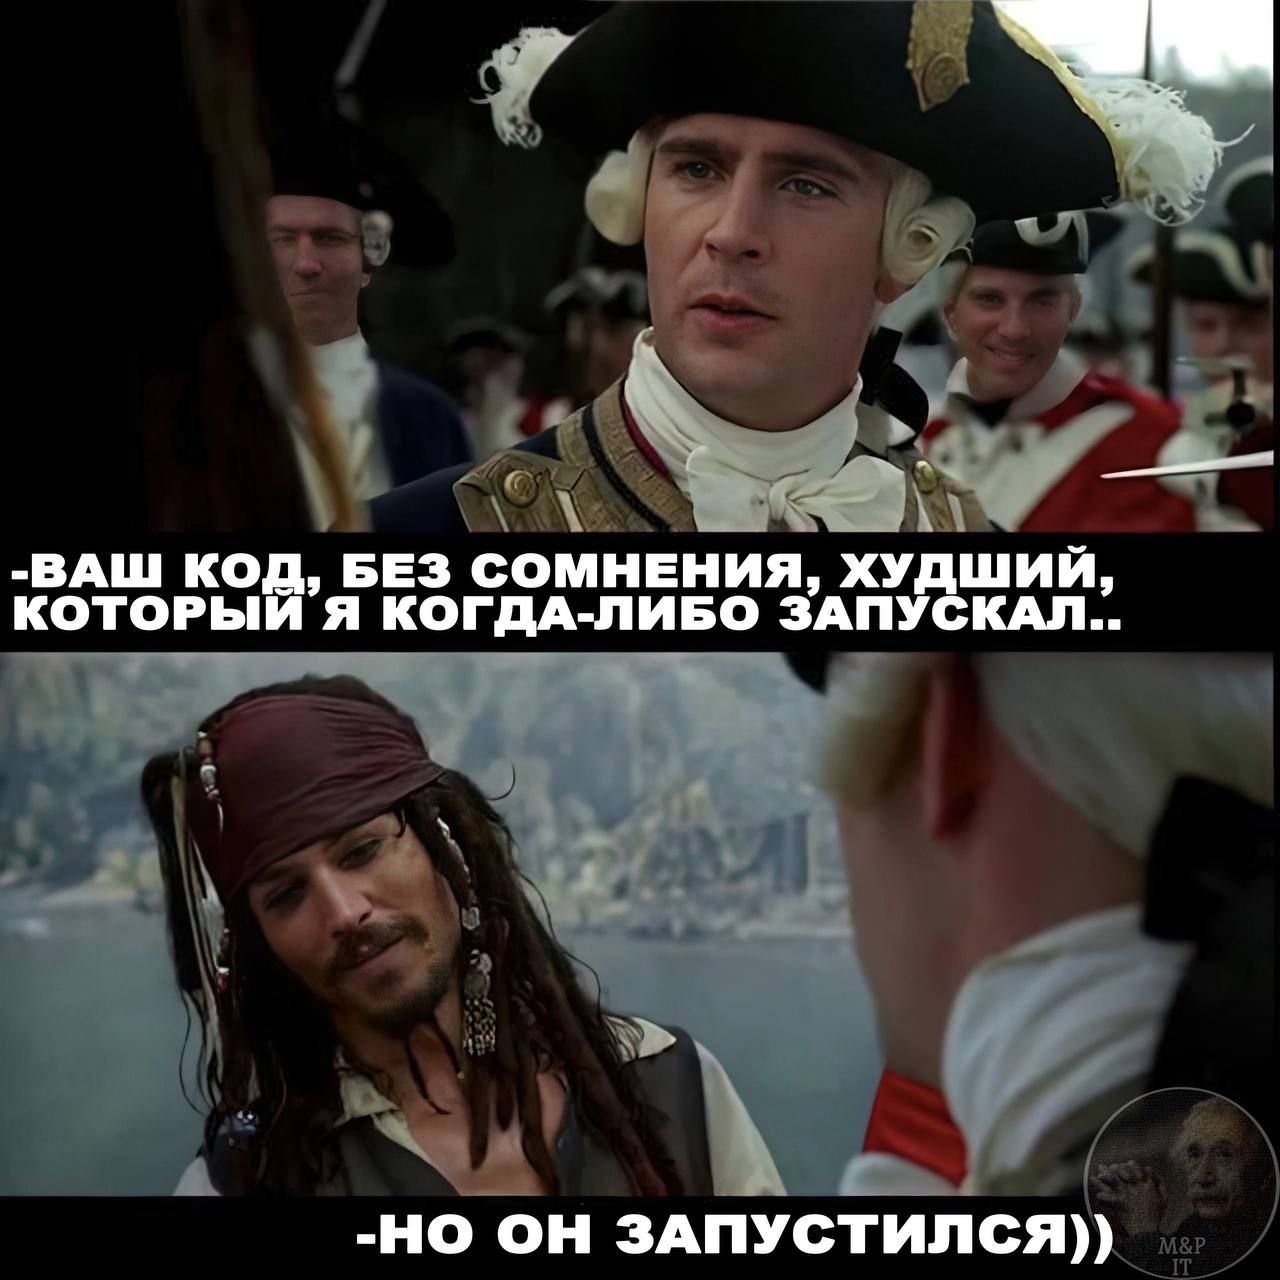

По второму пункту: добавила ресайз, сначала сделала 256 на 256, но оно обучалось как черепаха, поэтому перешла на 128. еще подумала, что изменение цыета тоже лучше убрать, так как по картинке итак не особо что-то понятно, а colorjitter делает ее еще менее разборчивой и раз уж мне тяжело, то и нейронке вероятно тоже. Попробовала использовать efficientnet_b5 и efficientnet_b3, но они долго обучались (вероятно, из за большого количества параметров) и качество на первых эпоках показывали прям не очень (около 0,08 и я так и не осознала почему). Опустилась до b1 и все стало хорошо :)

Если честно, домашка получилась практически полным копипастом с семинара и заключалась в том, чтобы просто перебрать кучу моделек. Вероятно, не хватает понимания какие модели, где лучше применять.